<a href="https://colab.research.google.com/github/Bhargavi-Kummara/MiniProject2/blob/main/MiniProject_Code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analytics on Stackoverflow Data

## Install and import dependencies

In [ ]:
pip install requests-html requests pandas

In [ ]:
import requests
from requests_html import HTML
import numpy as np
import pandas as pd
import random
import os
import time
import warnings
from tqdm import tqdm_notebook
from collections import Counter
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (10.0, 10.0)

## Scraping multiple pages

### Function for Data Manipulation and Cleaning

In [ ]:
def clean_scraped_data(text, keyname=None):
    if keyname == 'user_name':
      return text.split("\n")[0]
    if keyname == 'votes':
        return text.replace('\nvotes', '')
    if keyname == 'views':
        return text.replace(' views', '')
    if keyname == 'num_answers':
      if text != '1answer':
        return text.replace('answers', '')
      else:
        return text.replace('answer', '')
    return text

### Function for Parsing the web page

In [ ]:
def parse_tagged_page(html):
    question_summaries = html.find(".question-summary")
    key_names = ['question', 'votes', 'views', 'num_answers', 'tags', 'user_name', 'date']
    classes_names = ['.question-hyperlink', '.vote', '.views', '.status', '.tags', '.user-details', '.relativetime']
    datas = []
    for el in question_summaries:
        question_data = {} 
        for i, _class in enumerate(classes_names):
            sub_el = el.find(_class, first=True)
            keyname = key_names[i]
            question_data[keyname] = clean_scraped_data(sub_el.text, keyname=keyname)

        datas.append(question_data)
    return datas

### Function for Extracting the data from url

In [ ]:
def extract_data_from_url(url):
    res = requests.get(url)
    if res.status_code not in range(200, 299):
        return []
    html_str = res.text
    html = HTML(html=html_str)
    datas = parse_tagged_page(html)
    return datas

### Main function for Scraping data 

In [ ]:
def scrape_tag(tag = "iot", query_filter = "MostFrequent", max_pages=2):
    base_url = 'https://stackoverflow.com/questions/tagged/'
    datas = []
    for p in range(max_pages):
        page_num = p + 1
        url = f"{base_url}{tag}?sort={query_filter}&page={page_num}"
        datas += extract_data_from_url(url)
        time.sleep(1.2)
    return datas

In [ ]:
datas = scrape_tag()

#Scraped data
datas

[{'date': "Dec 13 '20 at 17:36",
  'num_answers': '5',
  'question': 'Mosquitto: Starting in local only mode',
  'tags': 'networking mqtt iot mosquitto',
  'user_name': 'FlasH',
  'views': '20k',
  'votes': '8'},
 {'date': "Dec 15 '15 at 8:43",
  'num_answers': '3',
  'question': 'RFID RC522 Raspberry PI 2 Windows IOT',
  'tags': 'c# raspberry-pi2 iot windows-10-iot-core windowsiot',
  'user_name': 'David',
  'views': '19k',
  'votes': '8'},
 {'date': "Apr 15 '16 at 17:12",
  'num_answers': '2',
  'question': 'Send request over WiFi (without connection) even if Mobile data is ON (with connection) on Android M',
  'tags': 'android networking android-wifi android-6.0-marshmallow iot',
  'user_name': 'Alessandro Muzzi',
  'views': '8k',
  'votes': '19'},
 {'date': "May 23 '18 at 18:40",
  'num_answers': '1',
  'question': 'RPi python script fails to run from: /etc/rc.local, crontab, systemd',
  'tags': 'python json amazon-web-services raspberry-pi iot',
  'user_name': 'electronical',
  'v

In [ ]:
len(datas)

100

### Normalize the units


In [ ]:
df = pd.DataFrame(datas)
df.head()

,question,votes,views,num_answers,tags,user_name,date
0,Mosquitto: Starting in local only mode,8,20k,5,networking mqtt iot mosquitto,FlasH,Dec 13 '20 at 17:36
1,RFID RC522 Raspberry PI 2 Windows IOT,8,19k,3,c# raspberry-pi2 iot windows-10-iot-core windo...,David,Dec 15 '15 at 8:43
2,Send request over WiFi (without connection) ev...,19,8k,2,android networking android-wifi android-6.0-ma...,Alessandro Muzzi,Apr 15 '16 at 17:12
3,RPi python script fails to run from: /etc/rc.l...,0,2k,1,python json amazon-web-services raspberry-pi iot,electronical,May 23 '18 at 18:40
4,How to download android things OS source code?,5,7k,4,android iot android-things git-repo,Anirudh,Mar 7 '17 at 11:48


In [ ]:
#k -> 1000, m -> 10,00,000
unit = {'k':' * 10**3', 'm':' * 10**6'}

df['views'] = pd.eval(df.views.replace(unit.keys(), unit.values(), regex=True).str.replace(r'[^\d\.\*]+',''))
df.head()

,question,votes,views,num_answers,tags,user_name,date
0,Mosquitto: Starting in local only mode,8,20000,5,networking mqtt iot mosquitto,FlasH,Dec 13 '20 at 17:36
1,RFID RC522 Raspberry PI 2 Windows IOT,8,19000,3,c# raspberry-pi2 iot windows-10-iot-core windo...,David,Dec 15 '15 at 8:43
2,Send request over WiFi (without connection) ev...,19,8000,2,android networking android-wifi android-6.0-ma...,Alessandro Muzzi,Apr 15 '16 at 17:12
3,RPi python script fails to run from: /etc/rc.l...,0,2000,1,python json amazon-web-services raspberry-pi iot,electronical,May 23 '18 at 18:40
4,How to download android things OS source code?,5,7000,4,android iot android-things git-repo,Anirudh,Mar 7 '17 at 11:48


In [ ]:
df.shape

(100, 7)

### Save the scraped data in .csv format

In [ ]:
df.to_csv("iot_scraped.csv", index=False)

## Exploratory Data Analysis on the scraped data

### Which tags are popularly used by Stackoverflow community in IoT domain?

  0%|          | 0/100 [00:00<?, ?it/s]

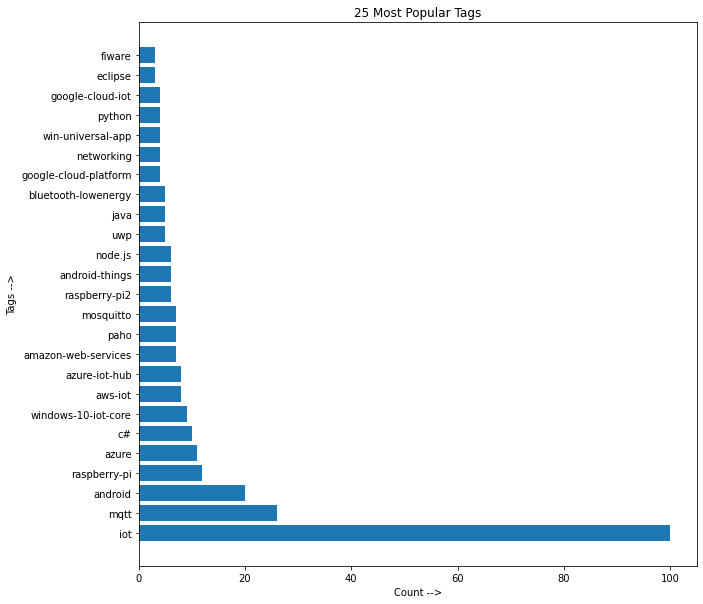

In [ ]:
tags_list = list(df['tags'].unique())
all_tags = []
for tag in tqdm_notebook(tags_list):
    all_tags += tag.split(' ')

count_tags = Counter(all_tags)
tags_list = pd.DataFrame([list(count_tags.keys()), list(count_tags.values())])
tags_list = tags_list.transpose()
tags_list.columns = ['tags', 'counts']
tags_list = tags_list.sort_values(by='counts', ascending=False)

plt.barh(list(tags_list['tags'])[:25], list(tags_list['counts'])[:25])
plt.ylabel('Tags -->')
plt.xlabel('Count -->')
plt.title('25 Most Popular Tags')
plt.show()

### Which are the most popular programming language tags used in IoT domain?

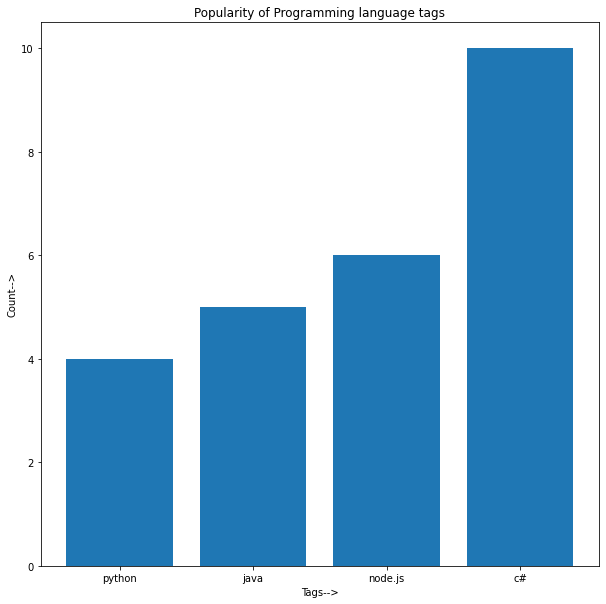

In [ ]:
programming_languages = ['python', 'java', 'node.js', 'c#']

x = []
y = []

for tag in programming_languages:
    index = list(tags_list['tags']).index(tag)
    x.append(tag)
    y.append(list(tags_list['counts'])[index])

plt.bar(x, y)
plt.ylabel('Count-->')
plt.xlabel('Tags-->')
plt.title('Popularity of Programming language tags')
plt.show()

### How many tags are present per question?

  0%|          | 0/100 [00:00<?, ?it/s]

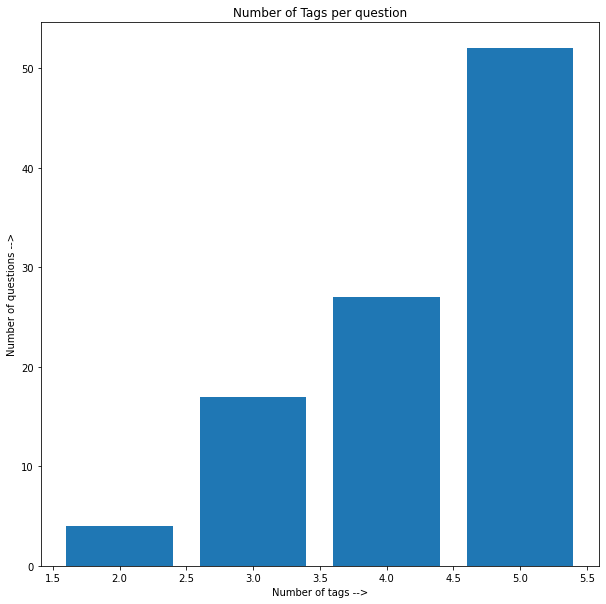

In [ ]:
tags = list(df['tags'].unique())
num_tags = []

for tag_ in tqdm_notebook(tags):
    num_tags.append(len(tag_.split(' ')))

num_tags = Counter(num_tags)

plt.bar(list(num_tags.keys()), list(num_tags.values()))
plt.xlabel('Number of tags -->')
plt.ylabel('Number of questions -->')
plt.title('Number of Tags per question')
plt.show()

### Are the number of views of question related to number of answers?

In [ ]:
view_q = df[['views', 'num_answers']].drop_duplicates().reset_index(drop=True)
view_q.head()

,views,num_answers
0,20000,5
1,19000,3
2,8000,2
3,2000,1
4,7000,4


In [ ]:
view_q.astype(int).describe()

,views,num_answers
count,66.000000,66.000000
mean,5095.848485,2.196970
std,7012.082329,1.541425
min,97.000000,0.000000
25%,651.250000,1.000000
50%,2000.000000,2.000000
75%,6750.000000,3.000000
max,37000.000000,9.000000


### Are the tags mentioned in questions similar to each other?

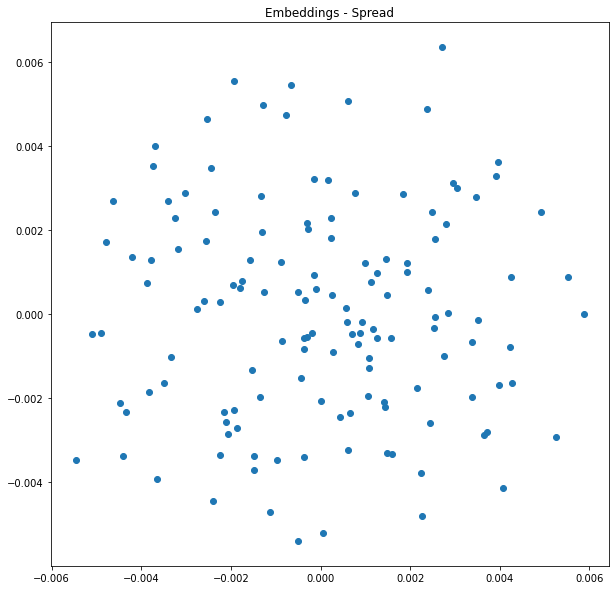

In [ ]:
tags = []
for tag in list(df['tags']):
    tags.append(tag.split(' '))

embedding = Word2Vec(tags, sg=1, size=256, min_count=1)

X = embedding[embedding.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Embeddings - Spread')
plt.show()

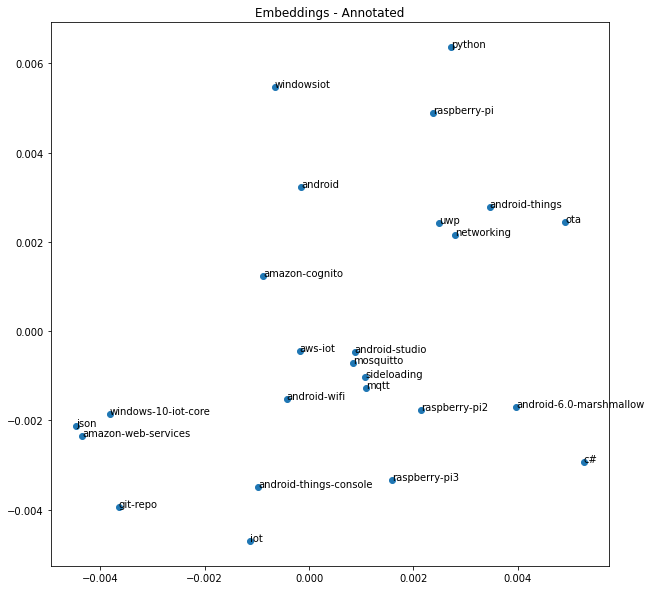

In [ ]:
i = 25

fig, ax = plt.subplots()
ax.set_title('Embeddings - Annotated')
ax.scatter(result[:i, 0], result[:i, 1])

for j, txt in enumerate(list(embedding.wv.vocab)[:i]):
    ax.annotate(txt, result[j])

Text(-0.004348462, -0.0023412816, 'amazon-web-services')

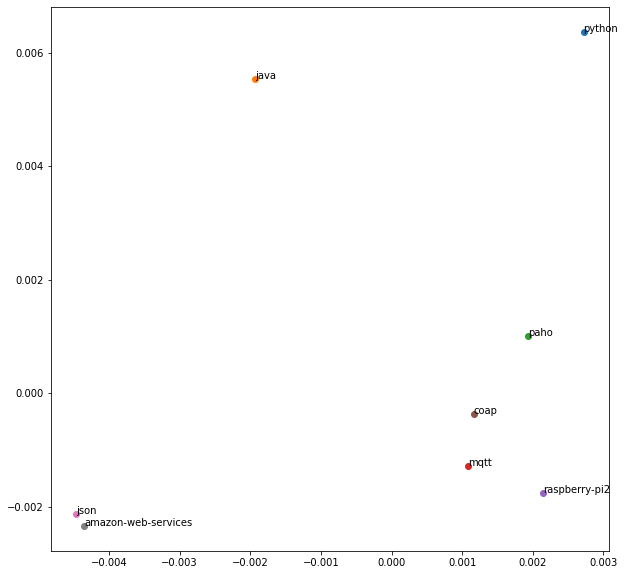

In [ ]:
w1 = 'python'
w2 = 'java'
w3 = 'paho'
w4 = 'mqtt'
w5 = 'raspberry-pi2'
w6 = 'coap'
w7 = 'json'
w8 = 'amazon-web-services'

word_list = list(embedding.wv.vocab)
i1 = word_list.index(w1)
i2 = word_list.index(w2)
i3 = word_list.index(w3)
i4 = word_list.index(w4)
i5 = word_list.index(w5)
i6 = word_list.index(w6)
i7 = word_list.index(w7)
i8 = word_list.index(w8)

fig, ax = plt.subplots()
ax.scatter(result[i1, 0], result[i1, 1])
ax.scatter(result[i2, 0], result[i2, 1])
ax.scatter(result[i3, 0], result[i3, 1])
ax.scatter(result[i4, 0], result[i4, 1])
ax.scatter(result[i5, 0], result[i5, 1])
ax.scatter(result[i6, 0], result[i6, 1])
ax.scatter(result[i7, 0], result[i7, 1])
ax.scatter(result[i8, 0], result[i8, 1])

ax.annotate(w1, result[i1])
ax.annotate(w2, result[i2])
ax.annotate(w3, result[i3])
ax.annotate(w4, result[i4])
ax.annotate(w5, result[i5])
ax.annotate(w6, result[i6])
ax.annotate(w7, result[i7])
ax.annotate(w8, result[i8])

### Which tags attract the highest/lowest views?

In [ ]:
tag_views = df[['tags', 'views']].drop_duplicates().reset_index(drop=True)
tag_views.head()

,tags,views
0,networking mqtt iot mosquitto,20000
1,c# raspberry-pi2 iot windows-10-iot-core windo...,19000
2,android networking android-wifi android-6.0-ma...,8000
3,python json amazon-web-services raspberry-pi iot,2000
4,android iot android-things git-repo,7000


  0%|          | 0/100 [00:00<?, ?it/s]

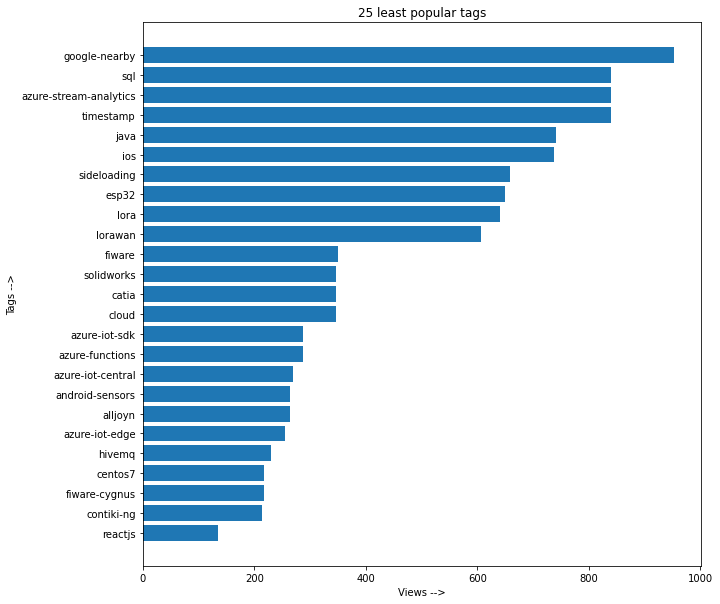

In [ ]:
tagView = {}
for i in tqdm_notebook(range(len(tag_views['tags']))):
    for tag in tag_views['tags'][i].split(' '):
        try:
            tagView[tag].append(tag_views['views'][i])
        except Exception:
            tagView[tag] = [tag_views['views'][i]]
tagViewAvg = {}
for key in list(tagView.keys()):
    tagViewAvg[key] = np.average(tagView[key])

tagViewAvg = pd.DataFrame([list(tagViewAvg.keys()), list(tagViewAvg.values())])
tagViewAvg = tagViewAvg.transpose()
tagViewAvg.columns = ['tags', 'views']
tagViewAvg = tagViewAvg.sort_values('views')

plt.barh(list(tagViewAvg['tags'])[:25], list(tagViewAvg['views'])[:25])
plt.xlabel('Views -->')
plt.ylabel('Tags -->')
plt.title('25 least popular tags')
plt.show()

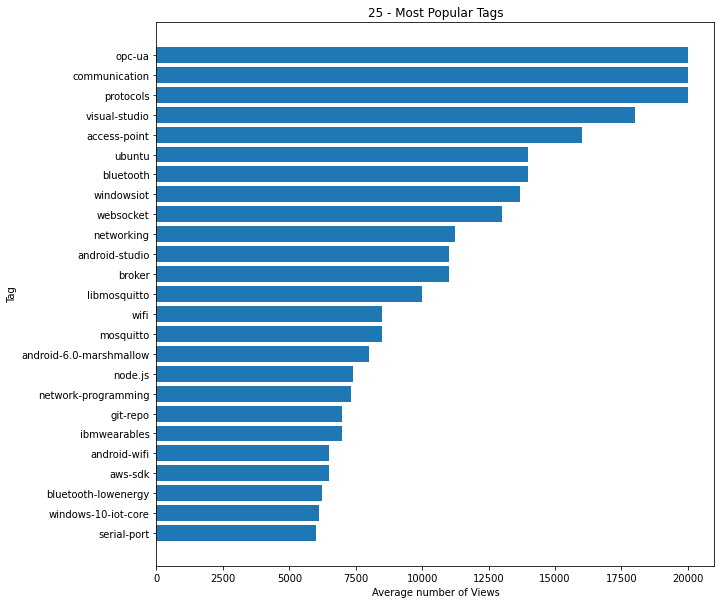

In [ ]:
plt.barh(list(tagViewAvg['tags'])[-25:], list(tagViewAvg['views'])[-25:])
plt.xlabel('Average number of Views')
plt.ylabel('Tag')
plt.title('25 - Most Popular Tags')
plt.show()

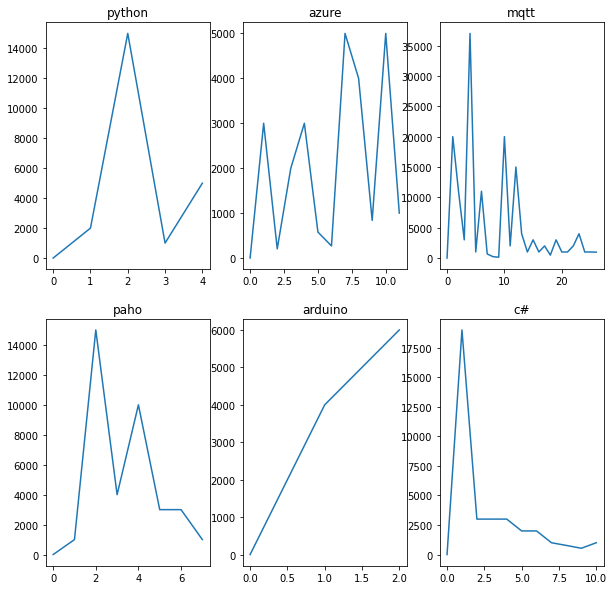

In [ ]:
fig, ax = plt.subplots(2, 3)

ax[0][0].plot([0] + tagView['python'])
ax[0][0].set_title('python')

ax[0][1].plot([0] + tagView['azure'])
ax[0][1].set_title('azure')

ax[0][2].plot([0] + tagView['mqtt'])
ax[0][2].set_title('mqtt')

ax[1][0].plot([0] + tagView['paho'])
ax[1][0].set_title('paho')

ax[1][1].plot([0] + tagView['arduino'])
ax[1][1].set_title('arduino')

ax[1][2].plot([0] + tagView['c#'])
ax[1][2].set_title('c#')
plt.show()

### Which Programming Language tags attract the highest/lowest views?

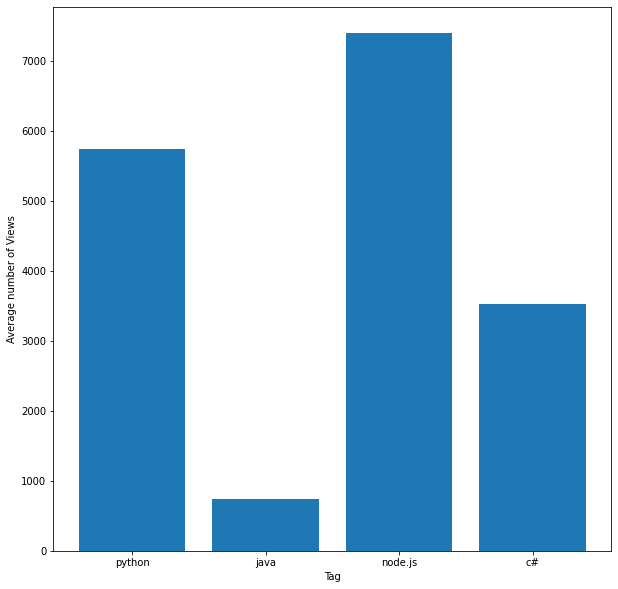

In [ ]:
programming_languages = ['python', 'java', 'node.js', 'c#']

x = []
y = []

for tag in programming_languages:
    index = list(tagViewAvg['tags']).index(tag)
    x.append(tag)
    y.append(list(tagViewAvg['views'])[index])

plt.bar(x, y)
plt.ylabel('Average number of Views')
plt.xlabel('Tag')
plt.show()

Text(0.5, 1.0, 'c#')

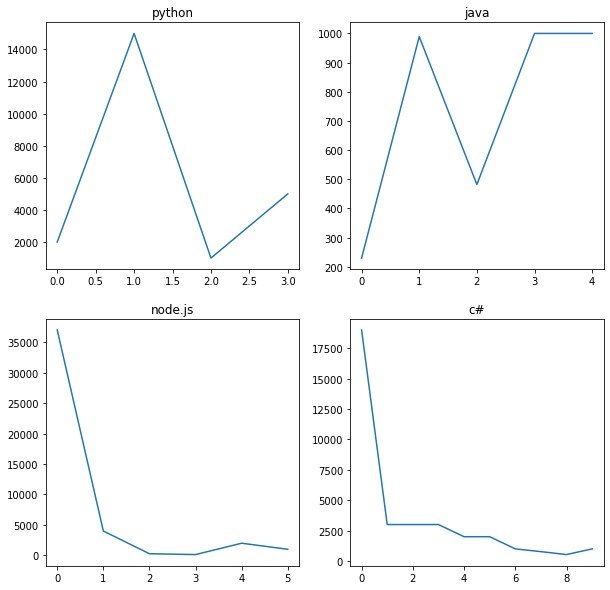

In [ ]:
fig, ax = plt.subplots(2, 2)
ax[0][0].plot(tagView['python'])
ax[0][0].set_title('python')

ax[0][1].plot(tagView['java'])
ax[0][1].set_title('java')

ax[1][0].plot(tagView['node.js'])
ax[1][0].set_title('node.js')

ax[1][1].plot(tagView['c#'])
ax[1][1].set_title('c#')